# Severity Projection

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

import data_cleansing as dc
import data_utils as du

## load the data and apply cleaning steps


In [2]:

data_train_raw, data_test_raw = dc.load_file()

data_test_raw = dc.clean_data(data_test_raw)
data_train_raw = dc.clean_data(data_train_raw)

data_test = data_test_raw.copy()
data_train = data_train_raw.copy()

## Setup the dataset 
Set the target

Drop target-related fields

Drop Density as this duplicated with density band

In [3]:
target_name='severity'

drop_list = [ 'Exposure', 'ClaimAmount', 'BonusMalus', 'Claim_xs000k', 'Claim_xs100k','Claim_xs500k', 'Density', 'ClaimNb']
data_train.drop(drop_list,axis='columns', inplace=True)
data_test.drop(drop_list,axis='columns', inplace=True)


## Cap the claim values to controll outliers


In [4]:
#cap large claims
severity_cap = 10e3
data_train[target_name] = data_train[target_name].where(data_train[target_name]<severity_cap, severity_cap)
data_test[target_name] = data_test[target_name].where(data_test[target_name]<severity_cap, severity_cap)


## Apply lable encoding to the factors

In [5]:

label_encode_factors = ['Area',
                        'VehPower',
                        'VehBrand',
                        'VehGas',
                        'Region',
                        'DrivAgeBand',
                        'DensityBand',
                        'VehAgeBand']
# encode training data and save encoders used
data_train_encoded, encoders = du.preprocess_labelencode(data_train, label_encode_factors)
# apply trained encoders to test set
data_test_encoded = du.preprocess_labelencode_apply(encoders, data_test, label_encode_factors)

## Remove policies with no claims (remove zeros)

In [6]:
data_train_resampled = data_train_encoded.loc[data_train_encoded[target_name]>0]
data_test_resampled = data_test_encoded.loc[data_test_encoded[target_name]>0]


# Setup the Random Forest model

## Split target from factors

In [7]:
#sets used to train (resampled sets)
x_train = data_train_resampled.drop(target_name, axis='columns')
y_train = data_train_resampled[target_name]

#sets used to predict (and evaluate prediction)
x_train_to_predict = data_train_resampled.drop(target_name, axis='columns')
y_train_to_predict = data_train_resampled[target_name]
x_test = data_test_resampled.drop(target_name, axis='columns')
y_test = data_test_resampled[target_name]


In [8]:
x_train.head()

,Area,VehPower,VehBrand,VehGas,Region,DrivAgeBand,DensityBand,VehAgeBand
RecordID,,,,,,,,
74,2,6,3,0,20,2,1,7
87,4,0,3,1,20,4,4,1
111,1,2,8,0,17,2,6,1
112,1,2,8,0,17,2,6,1
129,3,3,2,0,17,2,2,1


## Build the model and predict

In [9]:
%%time
clf_rf = RandomForestRegressor(min_samples_leaf=2, 
                                n_estimators=100,
                                max_depth=50,
                                max_features='auto',
                                criterion='mse',    #mse or mae
                                verbose=True,
                                oob_score=True,
                                n_jobs=3)
#fit values
clf_rf = clf_rf.fit(x_train.values, y_train.values)    
#predict values
y_train_predicted_rf = clf_rf.predict(x_train_to_predict.values)    
y_test_predicted_rf = clf_rf.predict(x_test.values)  

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


Wall time: 2.92 s


## Merge results back to data set

In [10]:
target_name_predicted = target_name + '_predicted'

x_train_to_predict[target_name_predicted] = y_train_predicted_rf
x_train_to_predict[target_name] = y_train_to_predict
x_test[target_name_predicted] = y_test_predicted_rf
x_test[target_name] = y_test

# Test the results 

In [14]:
# total claim results
train_results_actual= x_train_to_predict[target_name].sum()
train_results_predict = x_train_to_predict[target_name_predicted].sum()

test_results_actual= x_test[target_name].sum()
test_results_predict = x_test[target_name_predicted].sum()

test_results_gini = du.gini(x_test[target_name].values, x_test[target_name_predicted].values)
# gini results
train_results_gini = du.gini(x_train_to_predict[target_name].values, x_train_to_predict[target_name_predicted].values)
test_results_gini = du.gini(x_test[target_name].values, x_test[target_name_predicted].values)
# mean squared error
train_results_mse = np.sqrt(mean_squared_error(x_train_to_predict[target_name].values, x_train_to_predict[target_name_predicted].values))
test_results_mse = np.sqrt(mean_squared_error(x_test[target_name].values, x_test[target_name_predicted].values))



print('Total Claims: ', 'Tr Actual {:,.5f}'.format(train_results_actual),
      'Te Actual {:,.5f}'.format(test_results_actual))
print('Total Claims: ', 'Tr Predic {:,.5f}'.format(train_results_predict),
      'Te Predic {:,.5f}'.format(test_results_predict))

print('Results: ',
      'Tr_G {:,.5f}'.format(train_results_gini),
      'Te_G {:,.5f}'.format(test_results_gini),
      'Tr_rmse {:,.5f}'.format(train_results_mse),
      'Te_rmse {:,.5f}'.format(test_results_mse))

print('Factor Importance:\n', pd.DataFrame(zip(clf_rf.feature_importances_, x_train.columns)).sort_values(0))

Total Claims:  Tr Actual 24,632,939.59467 Te Actual 10,153,594.37033
Total Claims:  Tr Predic 25,214,800.08973 Te Predic 10,649,380.08546
Results:  Tr_G 0.19848 Te_G 0.01525 Tr_rmse 1,084.49948 Te_rmse 1,686.26469
Factor Importance:
           0            1
3  0.048429       VehGas
0  0.075140         Area
6  0.092080  DensityBand
4  0.135655       Region
2  0.144231     VehBrand
5  0.148585  DrivAgeBand
1  0.158249     VehPower
7  0.197632   VehAgeBand


# Review the Results in Charts

## Plot of distribution of results

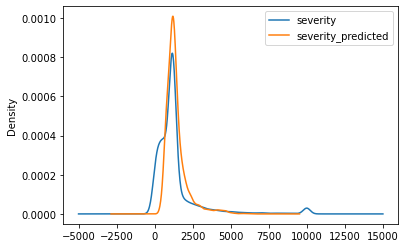

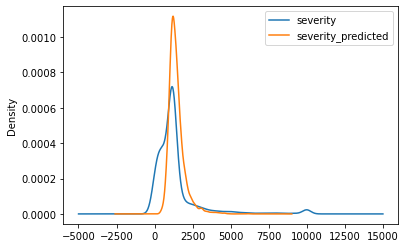

In [12]:
#%% plot distribution charts
x_train_to_predict[[target_name, target_name_predicted]].plot(kind='kde')
x_test[[target_name, target_name_predicted]].plot(kind='kde')


## Plot of mean claim numbers split by factor level

## Show fit of TRAIN data

Area
VehPower
VehBrand
VehGas
Region
DrivAgeBand
DensityBand
VehAgeBand


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


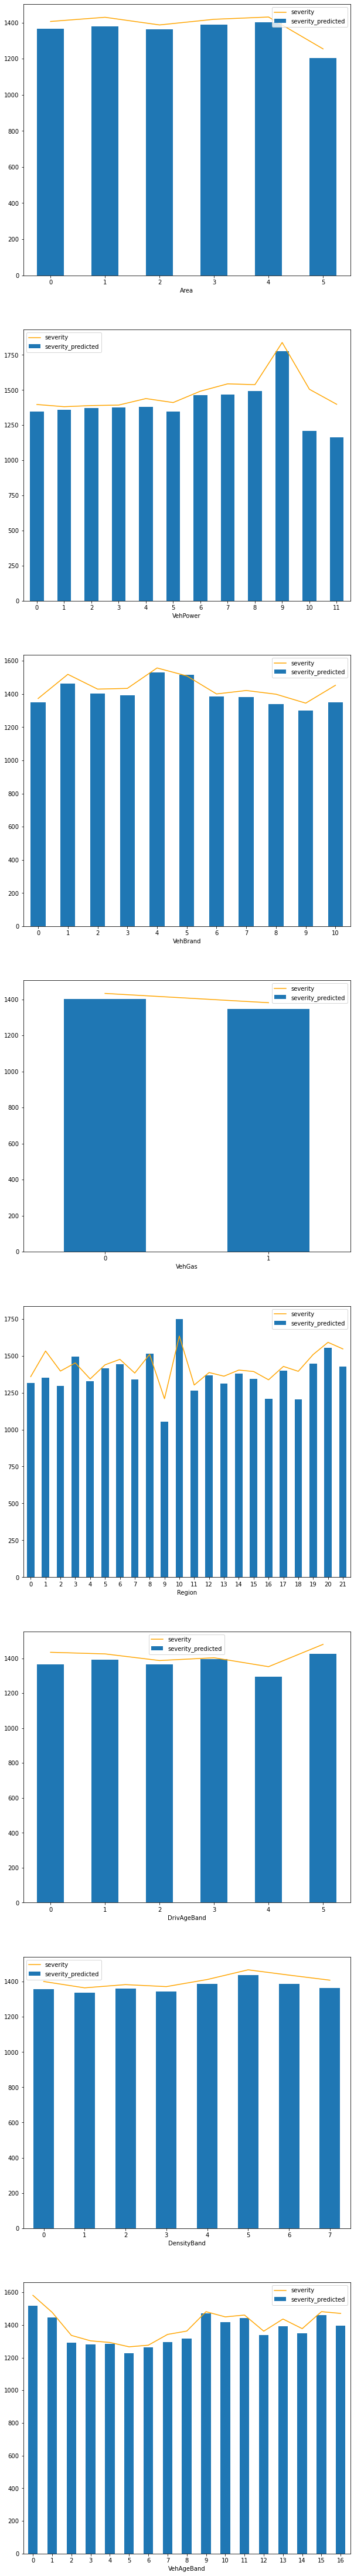

In [15]:
#%% bar charts of mean result
fig = du.plot_factors(x_train_to_predict, target_name, target_name_predicted)
fig.show()

### Plot fit of TEST data

Area
VehPower
VehBrand
VehGas
Region
DrivAgeBand
DensityBand
VehAgeBand


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


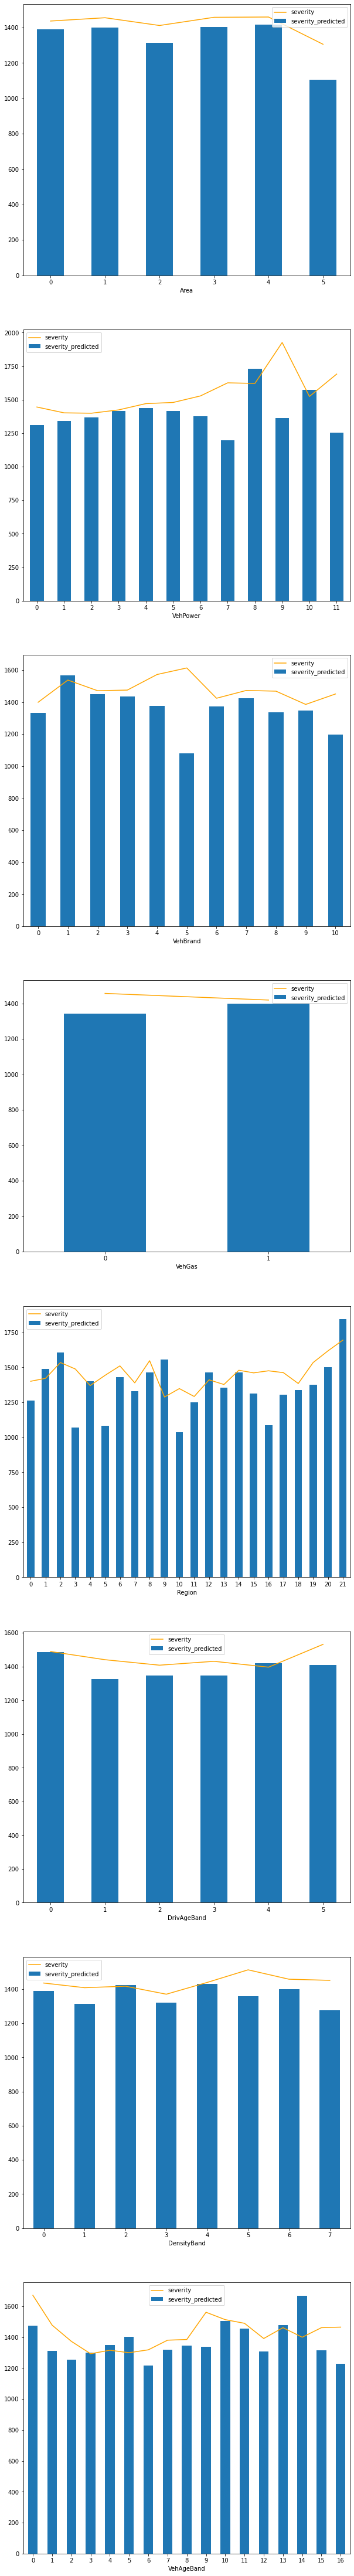

In [16]:
#%% bar charts of mean result
fig = du.plot_factors(x_test, target_name, target_name_predicted)
fig.show()